# Description

## "European Wholesale Electricity Price" by Ember

https://ember-climate.org/data-catalogue/european-wholesale-electricity-price-data/

- daily: prices are higher in the morning and evening as electricity consumption is usually higher during these hours
- weekly: Prices are higher on weekdays

N-BEATS model from Nixtla's neuralforecasty library

In [ ]:
!pip install neuralforecast

In [ ]:
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.6 MB/s eta 0:00:00


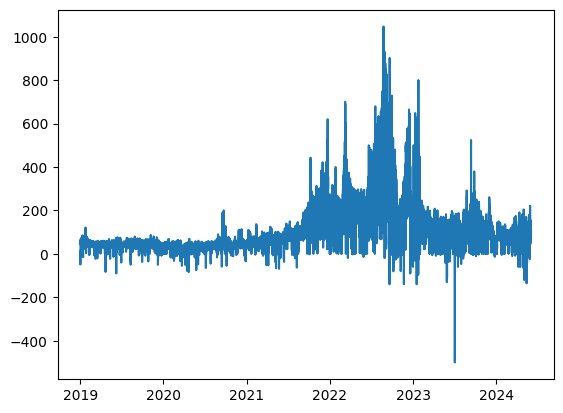

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuralforecast import NeuralForecast
from sklearn.metrics import mean_absolute_error

# importing data
price_data = pd.read_csv("/content/Germany.csv")
price_data = price_data[["Datetime (UTC)", "Price (EUR/MWhe)"]]

price_data["Datetime (UTC)"] = pd.to_datetime(price_data["Datetime (UTC)"])
price_data = price_data.loc[price_data["Datetime (UTC)"]>="2019-01-01"]
price_data.sort_values("Datetime (UTC)", inplace=True)

# 'ds': timpestamps, 'y': target value, 'unqiue_id': unique identifier, allows us to train a model on different time series simultaneously
price_data.rename(columns={"Price (EUR/MWhe)": "y", "Datetime (UTC)": "ds"}, inplace=True)
price_data["unique_id"] = 1

plt.plot(price_data["ds"], price_data["y"])

# Train-Test
- pandas datetime induces type error(or something similar), convert datetime to timestamps
- test on last 2 weeks

<ipython-input-19-3d4eb9124a82>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train_df["ds"] = Y_train_df["ds"].astype(int)


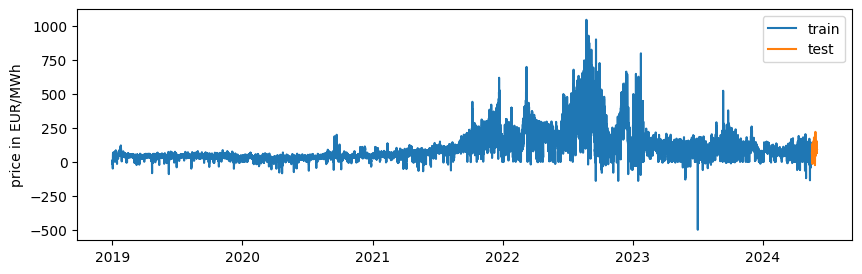

In [ ]:
# 2 weeks

forecast_horizon = 24*14

Y_train_df = price_data.iloc[:-forecast_horizon]
Y_test_df = price_data.iloc[-forecast_horizon:]

Y_train_df.reset_index(inplace = True, drop = True)
Y_test_df.reset_index(inplace = True, drop=True)

_, ax = plt.subplots(1, figsize=(10,3))
ax.plot(Y_train_df["ds"], Y_train_df["y"], label = "train")
ax.plot(Y_test_df["ds"], Y_test_df["y"], label="test")
ax.set_ylabel("price in EUR/MWh")
ax.legend()

Y_train_df["ds"] = Y_train_df["ds"].astype(int)

In [ ]:
def make_comparison_plot(y_pred, y_true):
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    print(f"MAE: {mae}")

    fig, ax = plt.subplots(2, figsize=(10,4))

    ax[0].plot(Y_test_df["ds"], y_true, label="true")
    ax[0].plot(Y_test_df["ds"], y_pred, label = "prediction")
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title(f"prediction vs. true (mean-absolute-error: {mae:.2f})")
    ax[0].set_ylabel("price in EUR/MWhe")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")

    ax[1].scatter(y_pred, y_true)
    max_val = np.min([y_pred.max(), y_true.max()])
    min_val = np.min([y_pred, y_true])
    ax[1].plot([min_val, max_val], [min_val, max_val], color = "r")
    ax[1].grid()
    ax[1].set_ylabel("actual price in EUR/MWh")
    ax[1].set_xlabel("predicted price in EUR/MWh")

    fig.tight_layout()

MAE: 40.66666659154929


<ipython-input-20-419897a0c446>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")


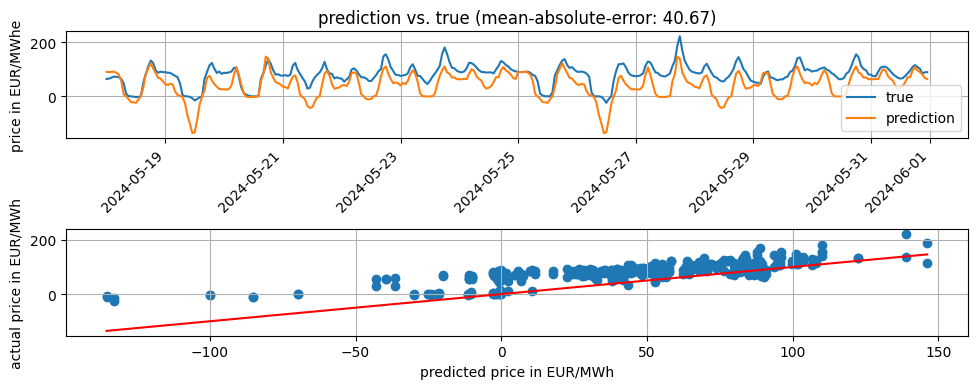

In [ ]:
from statsforecast.models import SeasonalNaive

model = SeasonalNaive(season_length=24*7)
model = model.fit(y=Y_train_df["y"])
y_pred_seasonal_naive = model.predict(h=forecast_horizon)

make_comparison_plot(y_pred=y_pred_seasonal_naive["mean"], y_true=Y_test_df["y"])

# Baseline model Result

The baseline Seasonal Naive model gives us a MAE of 40.67
Seems actually worse than the medium blog version
This will be compared to the N-BEATS model

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
1.8 M     Trainable params
675 K     Non-trainable params
2.5 M     Total params
9.981     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-20-419897a0c446>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")


MAE: 44.68211255028134


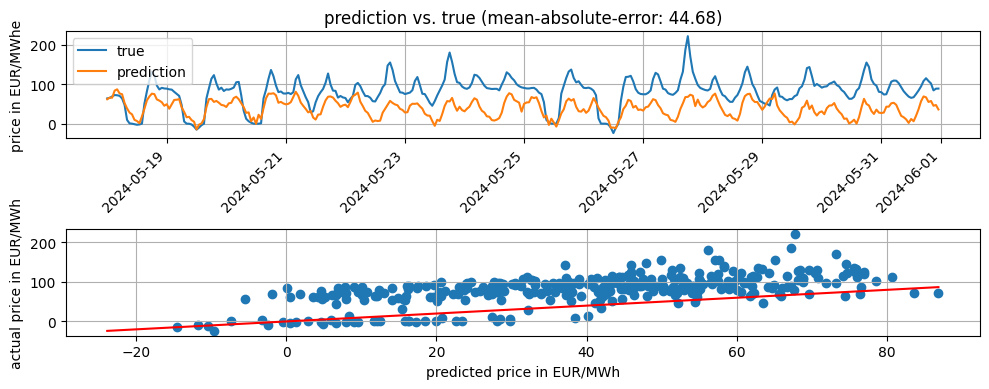

In [ ]:
from neuralforecast.models import NBEATS

model = NBEATS(
    h = forecast_horizon,
    input_size = 2 * forecast_horizon,
    stack_types = ["seasonality"],
    activation = "ReLU",
    num_lr_decays = 0,
    scaler_type="robust",
    max_steps = 100,
    val_check_steps=10,
    early_stop_patience_steps=2
)

fcst = NeuralForecast(models=[model], freq=3600)
fcst.fit(df=Y_train_df, val_size=2*forecast_horizon)
y_pred_nbeats = fcst.predict()

make_comparison_plot(y_pred=y_pred_nbeats["NBEATS"], y_true=Y_test_df["y"])

# N-BEATS Result

The blog had a slightly better result, but it got worse in this case.

Further tuning hyperparameters will be applied below.

Tuning is easy, "AutoNBEATS" will be used.

Ray is a framework for distributed computing.

Optuna which is designed for optimizing hyperparameters for ML using like Bayesian optimization will be used as identical to medium

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
[I 2024-06-15 12:22:59,979] A new study created in memory with name: no-name-bc77043f-091b-4c41-97d8-930609d26372
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:03,014] Trial 0 finished with value: 45.3693733215332 and parameters: {'scaler_type': 'robust', 'stack_types': ['seasonality'], 'activation': 'LeakyReLU', 'input_size': 2, 'random_seed': 19, 'batch_size': 128, 'windows_batch_size': 1024}. Best is trial 0 with value: 45.3693733215332.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:06,402] Trial 1 finished with value: 41.14495849609375 and parameters: {'scaler_type': 'standard', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 5, 'random_seed': 1, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserW

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:10,504] Trial 2 finished with value: 44.67112731933594 and parameters: {'scaler_type': 'standard', 'stack_types': ['trend'], 'activation': 'LeakyReLU', 'input_size': 3, 'random_seed': 6, 'batch_size': 32, 'windows_batch_size': 128}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: Use

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:14,286] Trial 3 finished with value: 45.591712951660156 and parameters: {'scaler_type': 'standard', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 2, 'random_seed': 11, 'batch_size': 256, 'windows_batch_size': 128}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: Us

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:17,960] Trial 4 finished with value: 45.18584060668945 and parameters: {'scaler_type': 'robust', 'stack_types': ['trend'], 'activation': 'LeakyReLU', 'input_size': 3, 'random_seed': 18, 'batch_size': 256, 'windows_batch_size': 256}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: Use

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:21,532] Trial 5 finished with value: 42.18208694458008 and parameters: {'scaler_type': 'robust', 'stack_types': ['seasonality'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 8, 'batch_size': 256, 'windows_batch_size': 256}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: Use

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:25,264] Trial 6 finished with value: 45.594947814941406 and parameters: {'scaler_type': 'robust', 'stack_types': ['seasonality'], 'activation': 'ReLU', 'input_size': 2, 'random_seed': 17, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: Us

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:28,735] Trial 7 finished with value: 43.52284622192383 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'LeakyReLU', 'input_size': 3, 'random_seed': 13, 'batch_size': 32, 'windows_batch_size': 1024}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:32,831] Trial 8 finished with value: 41.8762321472168 and parameters: {'scaler_type': 'standard', 'stack_types': ['trend', 'seasonality'], 'activation': 'ReLU', 'input_size': 4, 'random_seed': 10, 'batch_size': 64, 'windows_batch_size': 256}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:37,182] Trial 9 finished with value: 42.90443801879883 and parameters: {'scaler_type': 'robust', 'stack_types': ['trend', 'seasonality'], 'activation': 'LeakyReLU', 'input_size': 5, 'random_seed': 6, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 1 with value: 41.14495849609375.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distribution

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:40,843] Trial 10 finished with value: 40.12434387207031 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 1, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:44,644] Trial 11 finished with value: 40.221412658691406 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 2, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: Use

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:48,340] Trial 12 finished with value: 40.12434387207031 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 1, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:51,609] Trial 13 finished with value: 41.17458724975586 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 5, 'random_seed': 4, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:55,137] Trial 14 finished with value: 40.12434387207031 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 1, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:23:58,931] Trial 15 finished with value: 41.17458724975586 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 5, 'random_seed': 4, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:24:01,747] Trial 16 finished with value: 40.124656677246094 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 4, 'batch_size': 64, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:24:05,806] Trial 17 finished with value: 42.19999313354492 and parameters: {'scaler_type': 'minmax', 'stack_types': ['trend', 'seasonality'], 'activation': 'ReLU', 'input_size': 4, 'random_seed': 15, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:24:09,950] Trial 18 finished with value: 41.86353302001953 and parameters: {'scaler_type': 'minmax', 'stack_types': ['trend'], 'activation': 'ReLU', 'input_size': 6, 'random_seed': 7, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['identity'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['trend'] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWar

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
[I 2024-06-15 12:24:13,203] Trial 19 finished with value: 41.207550048828125 and parameters: {'scaler_type': 'minmax', 'stack_types': ['identity'], 'activation': 'ReLU', 'input_size': 5, 'random_seed': 3, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 10 with value: 40.12434387207031.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | Constan

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-20-419897a0c446>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")


MAE: 24.545045003436858


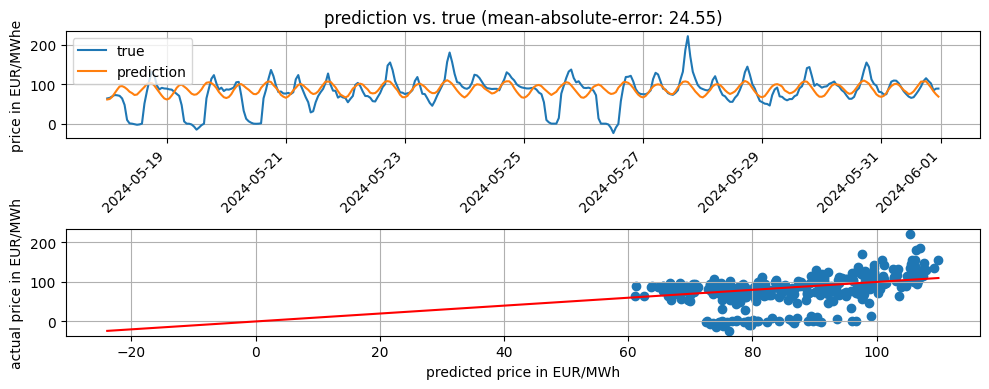

In [ ]:
import optuna
from neuralforecast.auto import AutoNBEATS
from neuralforecast.losses.pytorch import MAE

def config(trial):
    return{
        "scaler_type": trial.suggest_categorical("scaler_type", ["minmax","robust","standard"]),
        "stack_types": trial.suggest_categorical(
            "stack_types", [["identity"],["trend"],["seasonality"],["trend", "seasonality"]],
        ),
        "activation": trial.suggest_categorical("activation", ["ReLU","LeakyReLU"]),
        "num_lr_decays": trial.suggest_int("input_size", 2, 6),
        "input_size": trial.suggest_int("input_size", 2, 6),
        "random_seed": trial.suggest_int("random_seed", 1, 20),
        "batch_size": trial.suggest_categorical("batch_size", [32,64,128,256]),
        "windows_batch_size": trial.suggest_categorical(
            "windows_batch_size", [128,256,512,1024]
        ),
        "max_steps": 100,
    }

model = AutoNBEATS(
    h=forecast_horizon,
    loss=MAE(),
    config=config,
    search_alg=optuna.samplers.TPESampler(),
    backend="optuna",
    num_samples=20,
)

fcst = NeuralForecast(models=[model], freq=3600)
fcst.fit(df=Y_train_df, val_size=2 * forecast_horizon)

y_pred_autonbeats = fcst.predict()

make_comparison_plot(y_pred=y_pred_autonbeats["AutoNBEATS"], y_true=Y_test_df["y"])

# Autotuned NBEATS

mae: 24.71

significantly lower loss than both the baseline model and the vanilla nbeats!!

# Changing only fewer parameters

In [ ]:
default_config = Auto_NBEATS.get_default_config(h=forecast_horizon, backend="optuna")

def adapted_config(trial):
    config = {**default_config(trial)}
    config.update(
        {
            "max_steps": 100,
            "scaler_type": robust",
        }
    )
    return config

In [ ]:
results = fcst.models[0].results.trials_dataframe()

# NBEATS with exogenous variables
- "passing the day of the week to the model as there is a weekly seasonality"

In [ ]:
from neuralforecast.models import NBEATSx

model = NBEATSx(
    h=forecast_horizon,
    input_size=2*forecast_horizon,
    futr_exog_list=["weekday"],
    stack_types=["seasonality"],
    activation="ReLU",
    num_lr_decays=0,
    scaler_type="robust",
    max_steps=100,
    val_check_steps=10,
    early_stop_patience_steps=2,
)

fcst = NeuralForecast(models=[model], freq=3600)

Y_train_df["weekday"] = pd.to_datetime(Y_train_df["ds"]).dt.weekday
futr_df = Y_test_df.copy()
futr_df["weekday"] = futr_df["ds"].dt.weekday
futr_df["ds"]=futr_df["ds"].astype(int)

fcst.fit(df=Y_train_df, val_size=2*forecast_horizon)
y_pred_nbeatsx = fcst.predict(futr_df=futr_df)

make_comparison_plot(y_pred=y_pred_nbeatsx["NBEATSx"], y_true=Y_test_df["y"])

INFO:lightning_fabric.utilities.seed:Seed set to 1
<ipython-input-30-54f1bd063444>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train_df["weekday"] = pd.to_datetime(Y_train_df["ds"]).dt.weekday
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | Cons

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


ValueError: There are missing combinations of ids and times in `futr_df`.
You can run the `make_future_dataframe()` method to get the expected combinations or the `get_missing_future(futr_df)` method to get the missing combinations.